In [41]:
import math
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib
import random as rand
from matplotlib import pyplot as plt
from itertools import product
import itertools
import time
import re
import csv
from hurst import compute_Hc
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox
import tqdm

%matplotlib inline

In [42]:
plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [17., 8.]

## Import CSV data

In [43]:
data = pd.read_csv('data/improved_data.csv')
data.head(5)

,Id,price,volume
0,0,100.82,0.0
1,1,100.78,0.0
2,2,100.74,0.0
3,3,100.69,0.0
4,4,100.65,0.0


In [44]:
data['returns'] = data["price"].pct_change()

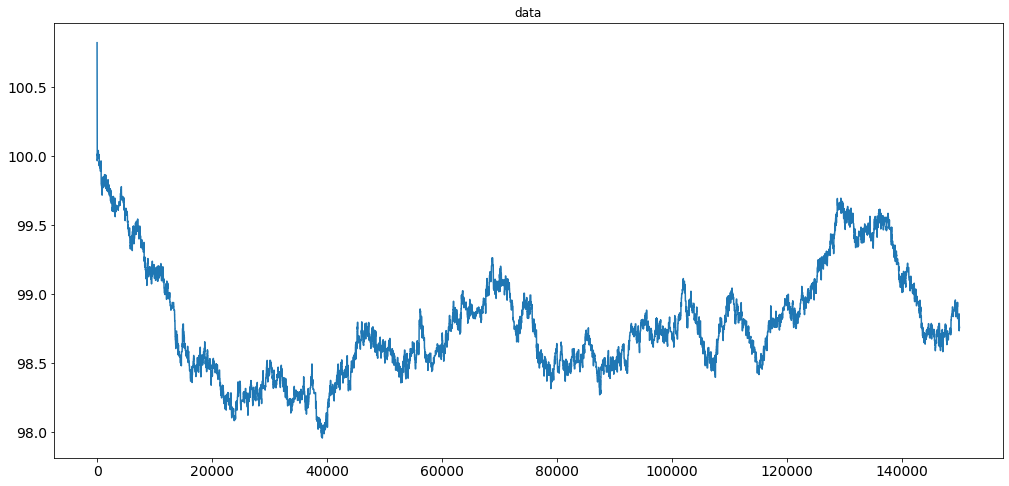

In [45]:
plt.plot(data['price'])
plt.title('data')
plt.show()

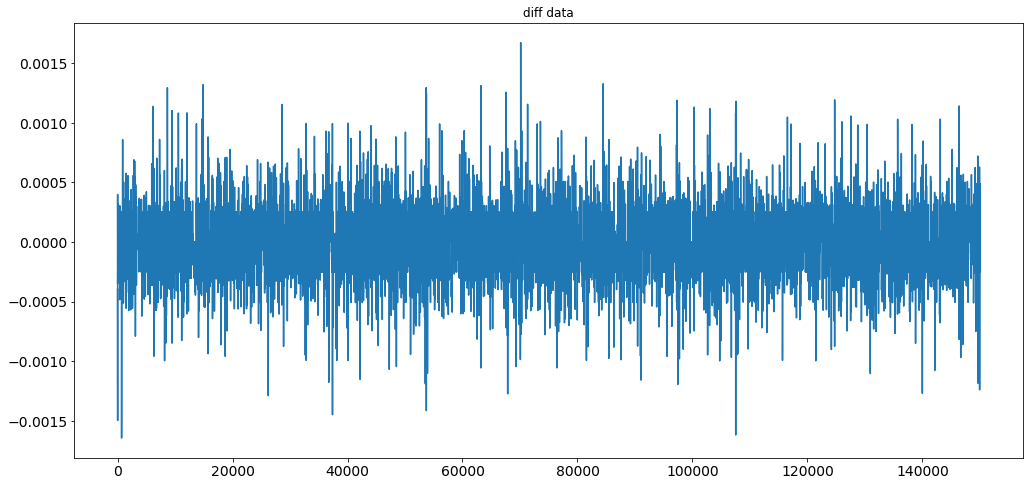

In [46]:
# returns_plot
plt.plot(data['returns'])
plt.title('diff data')
plt.show()

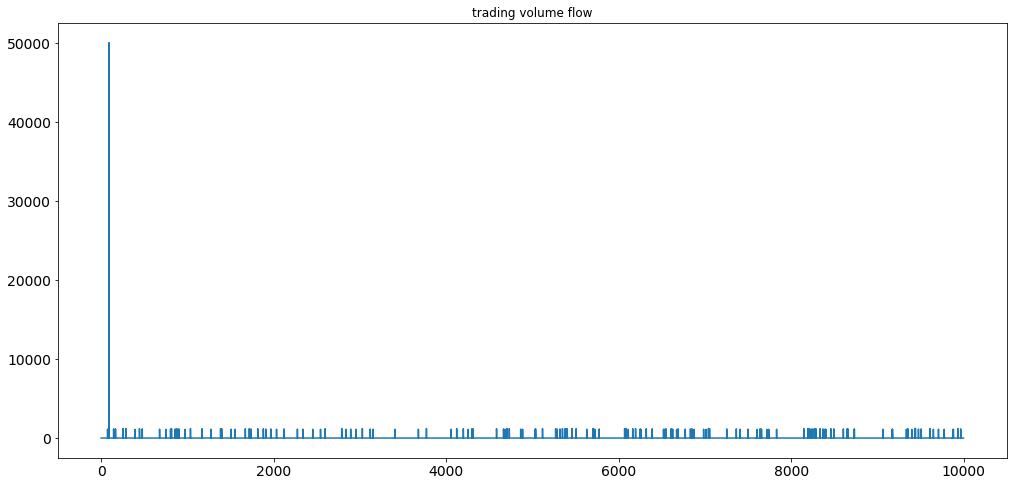

In [47]:
plt.plot(data['volume'][:10000])
plt.title('trading volume flow')
plt.show()

-------
Приведём ряд к стационарному и попробуем произвести преобразование Бокса- Кокса

Fat tailed distribution of returns

In [9]:
time = []
kurt = []

#kurt_list = [pd.DataFrame(np.diff(data['price'], k)).kurt() for k in range(3000)]
kurt_list_1 = [data["price"].pct_change(k).kurt() for k in range(2000)]

In [ ]:
plt.plot(kurt_list_1[5:])
plt.title('Kurtosis of returns and lags')
plt.xlabel('TimeScale')
plt.ylabel('Kurtosis value')
plt.grid(True)
plt.show()

## Volatility clustering

Можно оценить автокорреляцию и построить доверительный интервал  
Построить подобные графики для квадрата доходносетй  
Сделать GARCH fitting  

Проверить отсутствие линейной автокорреляции  
можно сделать fitting garch. 

---------

In [ ]:
H_list = []

for lag in range(1, 1000):
    H, c, Hurst_data = compute_Hc(data["price"].pct_change(lag).dropna().abs(), kind='change', simplified=True)
    H_list.append(H)

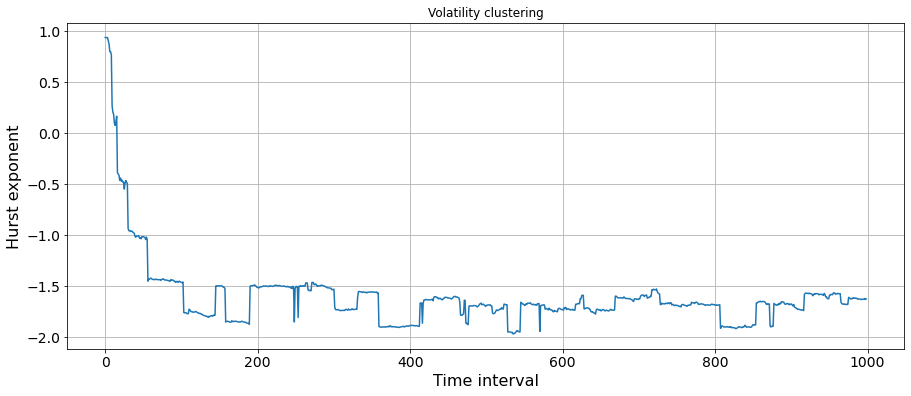

In [41]:
plt.plot(H_list)
plt.xlabel('Time interval')
plt.ylabel('Hurst exponent')
plt.title('Volatility clustering')
plt.grid(True)
plt.show()

Measure of long - term memory of time series

## Autocorrelation of returns

### 1) Dispersion stabilization

In [14]:
#BoxCox decomposition
data_box, lmbda = boxcox(data['price'])
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_box)[1])

Критерий Дики-Фуллера: p=0.998631


In [15]:
# simple differentiation
data_diff = np.diff(data['price'], 1)
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_diff)[1])

Критерий Дики-Фуллера: p=0.000000


In [12]:
#BoxCox decomposition
data_log = np.log(data['price'])
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_log)[1])

Критерий Дики-Фуллера: p=0.319609


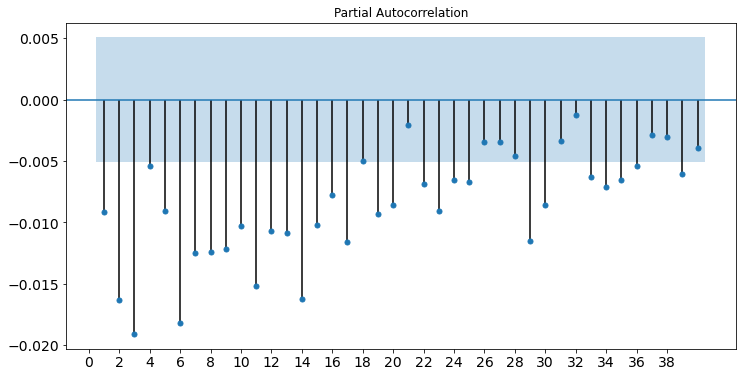

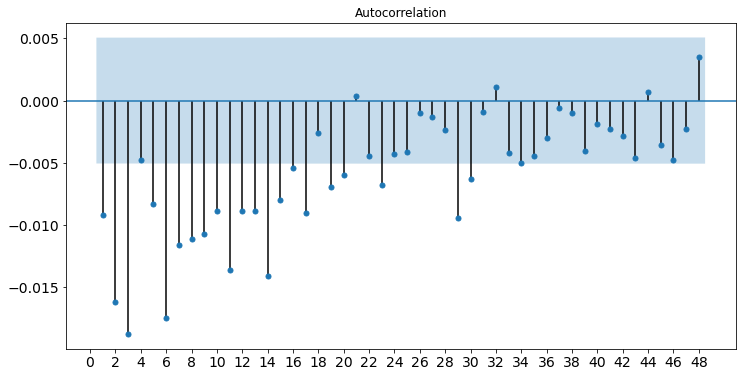

In [16]:
plt.rcParams['figure.figsize'] = (12,6)
plot_pacf(data_diff, lags=40, zero = False)
plt.xticks(np.arange(0, 40, 2))
plt.show()
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_diff, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Valued lag: 23

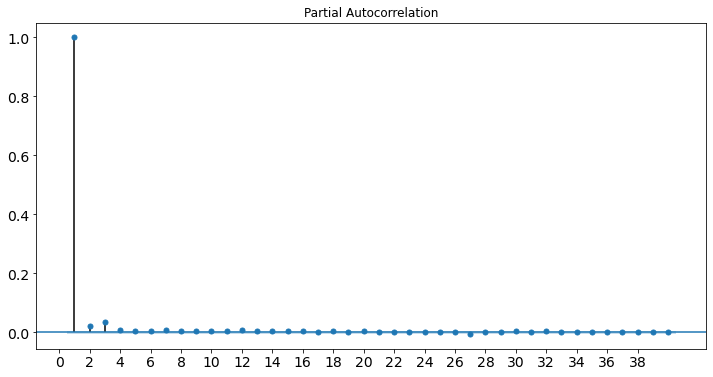

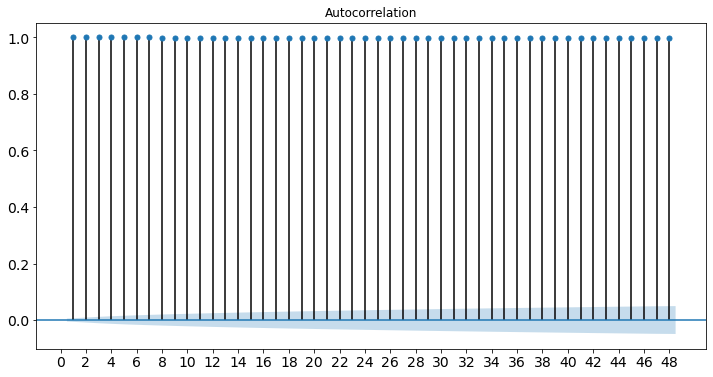

In [17]:
plt.rcParams['figure.figsize'] = (12,6)
plot_pacf(data_log, lags=40, zero = False)
plt.xticks(np.arange(0, 40, 2))
plt.show()
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_log, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.show()

In [137]:
# First lag returns of mid prices
corr_lags = np.correlate(data['price'][2:], data['price'][2:], mode = 'full')
res = corr_lags[len(corr_lags)//2:]

??????

In [138]:
summary = pd.DataFrame(res, columns=['Market statistics'])
summary.describe()

,Market statistics
count,1.500010e+05
mean,7.643473e+08
std,4.416219e+08
min,1.012744e+04
25%,3.812815e+08
50%,7.643498e+08
75%,1.147398e+09
max,1.528716e+09


## Long memory in order flow

In [ ]:
order_sides = pd.read_csv(f'/Users/admin/Workspace/apxr/output/apxr_order_sides{run}.csv', header=None)
order_sides.columns = ['side']

constraint = (order_sides['side'] == 0)
order_sides.loc[constraint, 'side'] = order_sides['side'] - 1

Откуда такие большие цифры?

In [124]:
# Mean first order lag autocorrelation of the order sign series
mean = np.mean(autocorrelation(data['volume']))
print("AC order sign series mean:", mean)

AC order sign series mean: 144651882.01556635


In [130]:
# Hurst exponent
H, c, data_vol = compute_Hc(data['volume'].dropna(), kind='change', simplified=True)
print("Hurst coeff order sign series:", H)

Hurst coeff order sign series: 0.8822005620882147


## Price impact

?????  
Очень странные значения!

In [165]:
price_impact = pd.DataFrame(data['volume'])
price_impact['impact'] = data['price']
price_impact['volume']+=1
price_impact['volume'] = np.log(price_impact['volume'])

In [168]:
x = price_impact['volume'].values.reshape(-1, 1)
y = price_impact['impact']

model = LinearRegression()
model.fit(x, y)

r_sq = model.score(x, y)
print('R^2:', r_sq)
print('Intercept:', model.intercept_)
print('Slope:', model.coef_)

R^2: 1.8562755008888487e-05
Intercept: 100.95163901632247
Slope: [-0.00156284]


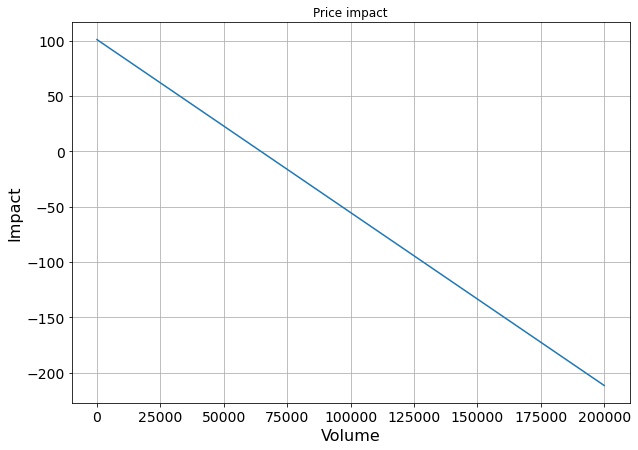

In [170]:
f, ax = plt.subplots(figsize=(10, 7))
plt.plot(np.arange(1, 200000), model.coef_ * np.arange(1, 200000) + model.intercept_)
ax.set_xlabel('Volume')
ax.set_ylabel('Impact')
ax.grid(True)
plt.title('Price impact')
plt.show()

## Extreme price events

In [249]:
def price_spikes(dat):
    sch_down = 0
    sch_up = 0
    down_scale = 0
    init_point = 0
    up_scale = 0
    i = 1
    while i < len(dat):
        if dat[i] <= dat[i-1]:
            #print(i)
            if (up_scale > 10) and (abs(dat[i-1] - dat[init_point]) > dat[init_point]*0.08 ):
                sch_down += 1
            if down_scale == 0:
                initial_point = i-1
            i+=up_scale
            up_scale = 0
            down_scale+=1
            i+=1
            continue

        elif dat[i] >= dat[i-1]:
            #print(i, down_scale, abs(dat[i] - dat[init_point]), dat[init_point]*0.08)
            if (down_scale > 10) and (abs(dat[i-1] - dat[init_point]) > dat[init_point]*0.08 ):
                sch_down += 1
            if up_scale == 0:
                initial_point = i-1
            i+=down_scale
            down_scale = 0
            up_scale+=1
            i+=1
            continue
        i+=1
    
    return (sch_down, sch_up)

In [251]:
price_spikes(dat)

(1, 0)

-------
### Let's show our row with new agent:

In [8]:
#data_long = pd.read_csv('data/long_trader.csv')
data_long = pd.read_csv('data/d222.csv')
data_long.head(5)

,Id,price,volume,bid_price,ask_price,bid_volume,ask_volume,MM1,LC1,MT1,MRT1,NT1
0,0,100.452500,100.000000,100.820,0.000000,0.0,0.000000,0,0,0,0,0
1,1,100.000000,100.000000,100.000,0.053710,0.0,0.857143,0,0,0,0,0
2,2,100.000000,100.000000,100.000,0.052783,0.0,-0.999766,0,0,0,0,0
3,3,99.980833,99.975000,100.000,0.049457,54121.0,-0.999963,0,0,0,0,0
4,4,99.967740,99.963537,99.975,0.023038,1124.0,-0.999953,0,0,0,0,0


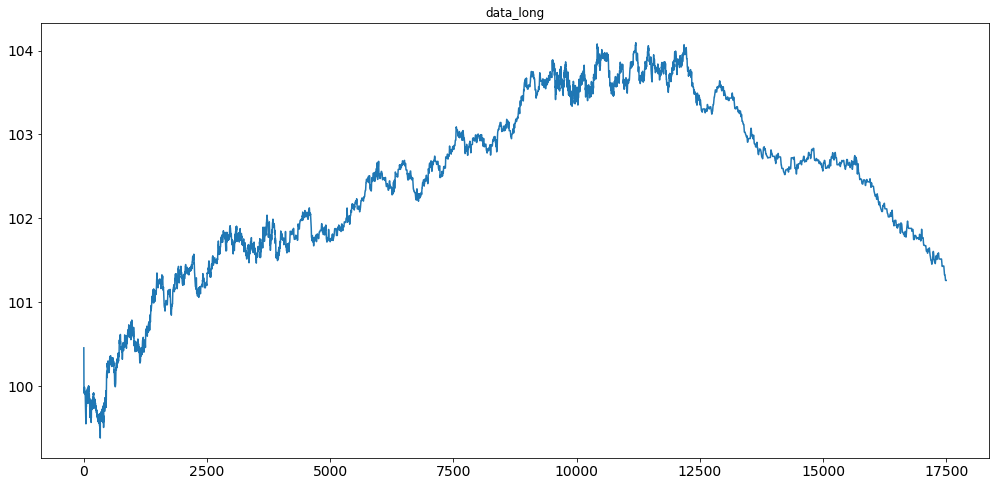

In [9]:
plt.plot(data_long.price)
plt.title('data_long')
plt.show()

In [16]:
data_long['returns'] = data_long["price"].pct_change()

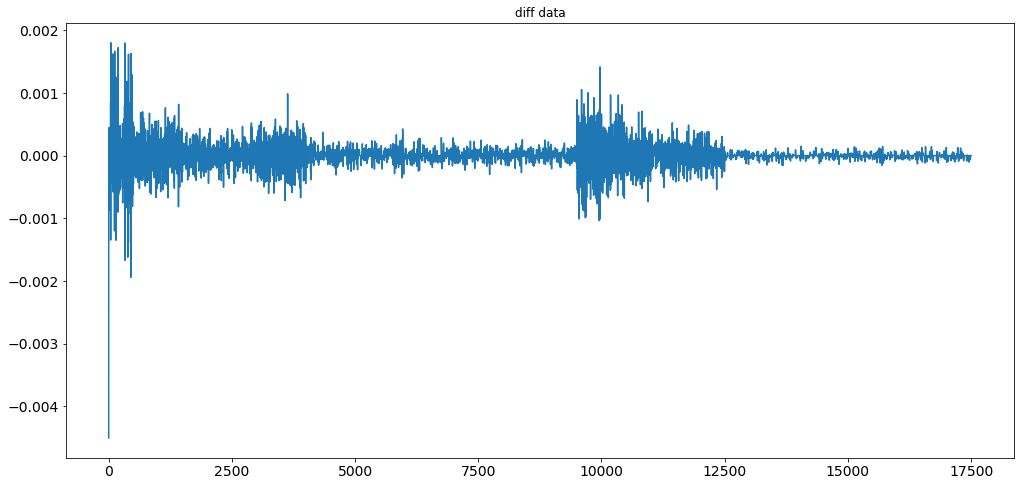

In [17]:
# returns_plot
plt.plot(data_long['returns'])
plt.title('diff data')
plt.show()

In [20]:
time = []
kurt = []

#kurt_list = [pd.DataFrame(np.diff(data['price'], k)).kurt() for k in range(3000)]
kurt_list_1 = [data_long["price"].pct_change(k).kurt() for k in range(2000)]

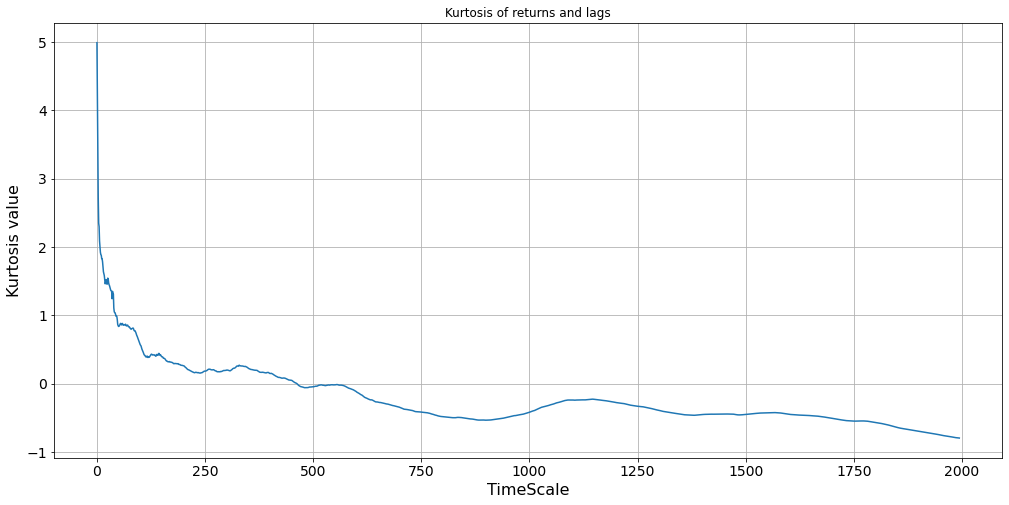

In [21]:
plt.plot(kurt_list_1[5:])
plt.title('Kurtosis of returns and lags')
plt.xlabel('TimeScale')
plt.ylabel('Kurtosis value')
plt.grid(True)
plt.show()

### Volatility clustering

In [22]:
H_list = []

for lag in range(1, 1000):
    H, c, Hurst_data = compute_Hc(data_long["price"].pct_change(lag).dropna().abs(), kind='change', simplified=True)
    H_list.append(H)

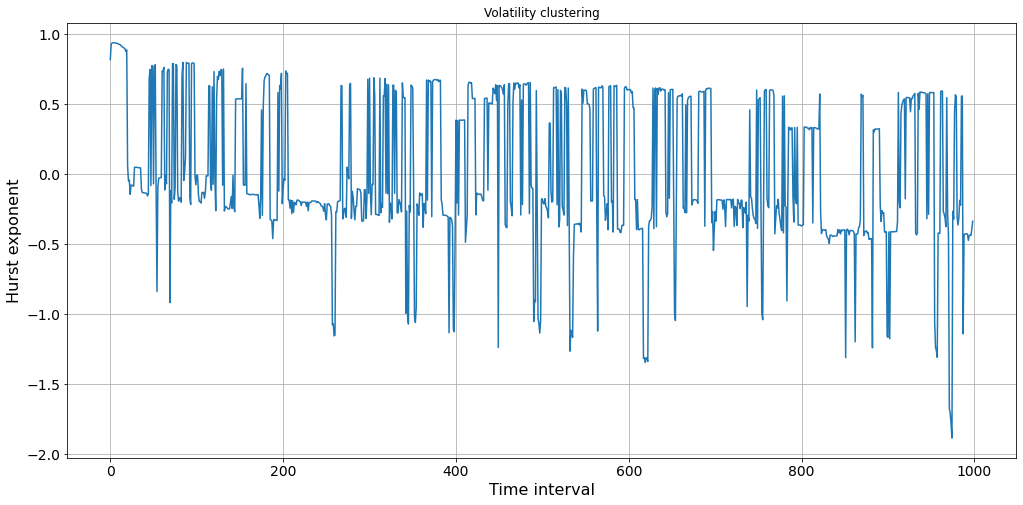

In [23]:
plt.plot(H_list)
plt.xlabel('Time interval')
plt.ylabel('Hurst exponent')
plt.title('Volatility clustering')
plt.grid(True)
plt.show()

### Autocorrelation

In [24]:
#BoxCox decomposition
data_box, lmbda = boxcox(data_long['price'])
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_box)[1])

Критерий Дики-Фуллера: p=0.964041


In [25]:
# simple differentiation
data_diff = np.diff(data_long['price'], 1)
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_diff)[1])

Критерий Дики-Фуллера: p=0.000000


In [26]:
#BoxCox decomposition
data_log = np.log(data_long['price'])
print('Критерий Дики-Фуллера: p=%f' % adfuller(data_log)[1])

Критерий Дики-Фуллера: p=0.137808


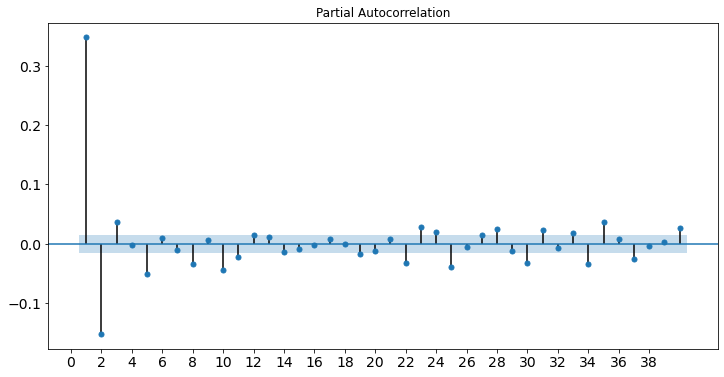

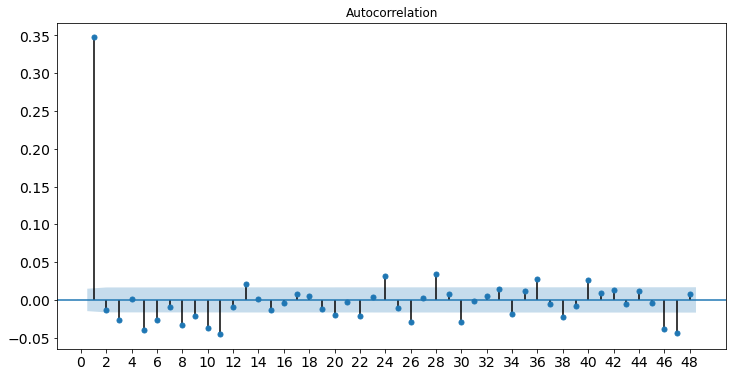

In [27]:
plt.rcParams['figure.figsize'] = (12,6)
plot_pacf(data_diff, lags=40, zero = False)
plt.xticks(np.arange(0, 40, 2))
plt.show()
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(data_diff, lags=48, zero = False)
plt.xticks(np.arange(0, 50, 2))
plt.show()

In [31]:
data_aggr = pd.read_csv('data/aggr_2.csv')
data_aggr.head(5)

,Id,close_price,min_price,max_price,spread,volume_data,volume_inb,macd,macdsignal,macdhist,data_rsi,data_obv
0,0,100.452500,100.000000,100.820000,0.000000,0.0,0.000000,0,0,0,0,0
1,1,100.007902,100.000000,100.039511,0.057990,2.0,-0.043478,0,0,0,0,0
2,2,100.070507,100.039511,100.135974,0.047487,8.0,-0.996752,0,0,0,0,0
3,3,100.184971,100.135974,100.202648,0.036979,31908.0,0.989769,0,0,0,0,0
4,4,100.149639,100.130363,100.202648,0.025759,1193.0,0.999962,0,0,0,0,0


In [32]:
data_def = pd.read_csv('data/long_trader_2.csv')
data_def.head(5)

,Id,price,volume,bid_price,ask_price,bid_volume,ask_volume,MM1,LC1,MT1,MRT1,NT1
0,0,100.82,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0
1,1,100.78,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0
2,2,100.74,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0
3,3,100.69,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0
4,4,100.65,0.0,100.0,100.0,1,1,0.0,0.0,0.0,0.0,0.0


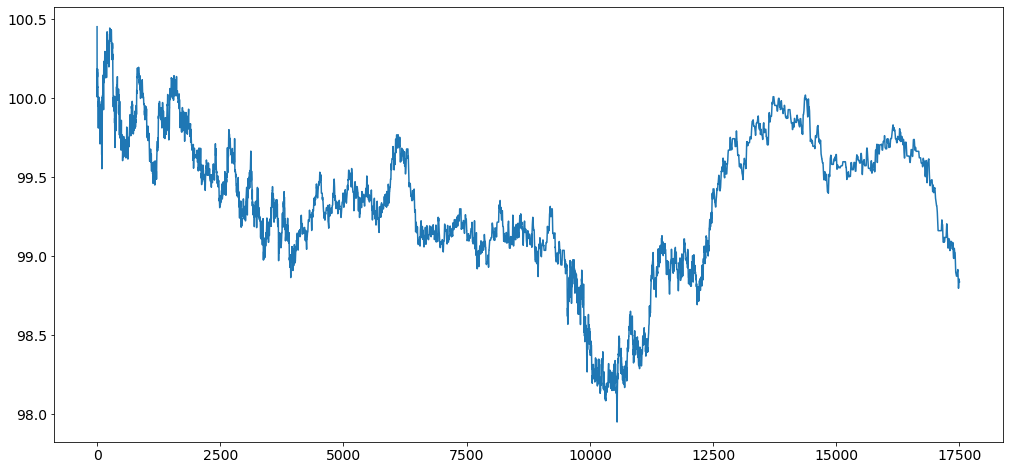

In [33]:
plt.plot(data_aggr.close_price)
plt.show()

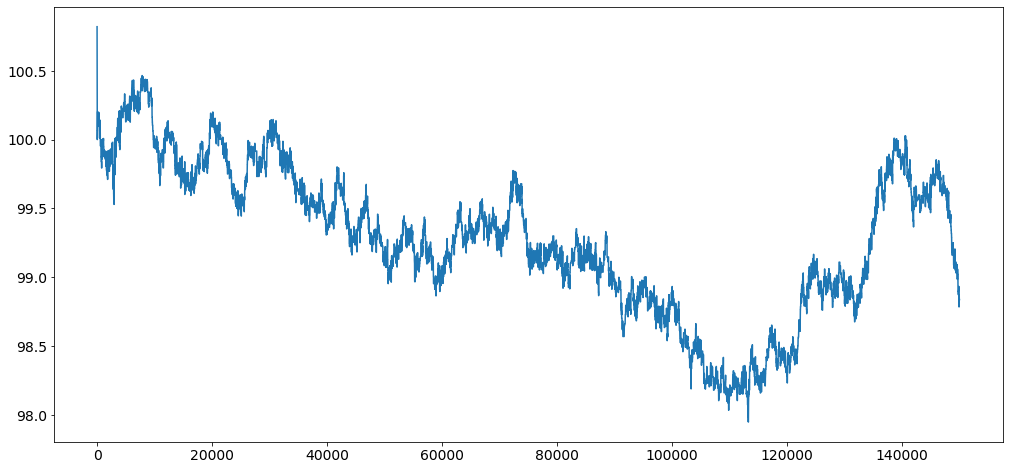

In [34]:
plt.plot(data_def.price)
plt.show()

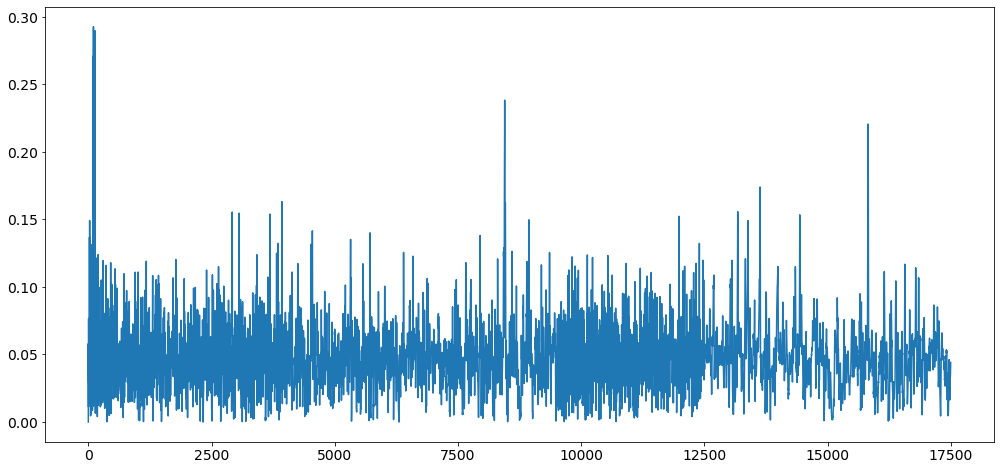

In [38]:
plt.plot(data_aggr.spread)
plt.show()